# VisualBacter

Detección de ETA's mediante vision computacional en redes nueronales convolucionales

Escrito por:

Juan Diego y George Giosue

## Setup data

In [1]:
import zipfile

data_path = '/content/data.zip'
lib_path= '/content/lib.zip'

extract_data_path = '/content/data'
extract_lib_path = '/content/lib'


with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall(extract_data_path)

print("Unzipped file in:", extract_data_path)

# Descomprimir el archivo zip
with zipfile.ZipFile(lib_path, 'r') as zip_ref:
    zip_ref.extractall(extract_lib_path)

print("Unzipped file in:", extract_lib_path)


Unzipped file in: /content/data
Unzipped file in: /content/lib


# Imports

In [2]:
import csv
import sys
import tensorflow as tf
import cv2
import numpy as np
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import string
from keras import Model
from keras.models import Sequential
from keras.layers import Layer
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, BatchNormalization, Permute, LSTM, Reshape, Concatenate, Lambda, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from os import scandir
from time import time

if '/content/lib' not in sys.path:
    sys.path.append('/content/lib')
import lib.utils as fns

tf.__version__

'2.15.0'

# GPU

In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices(), "\n\n", "Num GPUs Available: ",len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14865991528952250945
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14593358997486908465
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
] 

 Num GPUs Available:  1


### Avoid OOM errors by setting GPU Memory Consumption Growth

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


## Data preparation

In [5]:
TRAIN_DATA_PATH = "/content/data/data/train"
TEST_DATA_PATH = "/content/data/data/test"
VALID_DATA_PATH = "/content/data/data/valid"

TRAIN_CLASSES = {
  "filename" : "_classes.csv",
  "fields" : [],
  "rows" : []
}

TEST_CLASSES = {
  "filename" : "_classes.csv",
  "fields" : [],
  "rows" : []
}

VALID_CLASSES = {
  "filename" : "_classes.csv",
  "fields" : [],
  "rows" : []
}

train_data = []
test_data = []
valid_data = []

with open(TRAIN_DATA_PATH+"/"+TRAIN_CLASSES['filename'], 'r') as csvfile:
    csvreader = csv.reader(csvfile)

    columns = next(csvreader)

    for column in columns:
      TRAIN_CLASSES['fields'].append(column.strip())

    for row in csvreader:
        TRAIN_CLASSES['rows'].append(row)


with open(TEST_DATA_PATH+"/"+TEST_CLASSES['filename'], 'r') as csvfile:
    csvreader = csv.reader(csvfile)

    columns = next(csvreader)

    for column in columns:
      TEST_CLASSES['fields'].append(column.strip())

    for row in csvreader:
        TEST_CLASSES['rows'].append(row)

with open(VALID_DATA_PATH+"/"+VALID_CLASSES['filename'], 'r') as csvfile:
    csvreader = csv.reader(csvfile)

    columns = next(csvreader)

    for column in columns:
      VALID_CLASSES['fields'].append(column.strip())

    for row in csvreader:
        VALID_CLASSES['rows'].append(row)

def compose_images_with_class(payload, image_name, data_frame):
  target_row = []

  for row in data_frame["rows"]:
    if row[0] == image_name:
      target_row = row



  features = data_frame["fields"][1::]
  predictions = [int(p) for p in target_row[1::]]

  index_p = 0
  prediction = ''

  for index, p in enumerate(predictions):
    if p == 1:
      index_p = index

  prediction = features[index_p]


  return {
    "image": payload,
    "image_name": image_name,
    "classname": prediction
  }

CLASS_NAMES = ['Campylobacter', 'E.Coli', 'Staphylococcus', 'Streptococcus', 'Yeast']

train_data = fns.imgs_to_array(TRAIN_DATA_PATH,'_classes.csv',cv2.IMREAD_GRAYSCALE, lambda payload, image_name: compose_images_with_class(payload, image_name, TRAIN_CLASSES))

test_data = fns.imgs_to_array(TEST_DATA_PATH, '_classes.csv', cv2.IMREAD_GRAYSCALE, lambda payload, image_name: compose_images_with_class(payload, image_name, TEST_CLASSES))

valid_data = fns.imgs_to_array(VALID_DATA_PATH, '_classes.csv', cv2.IMREAD_GRAYSCALE, lambda payload, image_name: compose_images_with_class(payload, image_name, VALID_CLASSES))

print(f"""
      SIZE OF TRAIN DATA: {len(train_data)}
      SIZE OF TEST DATA: {len(test_data)}
      SIZE OF VALID DATA: {len(valid_data)}
      """)


      SIZE OF TRAIN DATA: 390
      SIZE OF TEST DATA: 26
      SIZE OF VALID DATA: 41
      


## Show Preview of Train Data

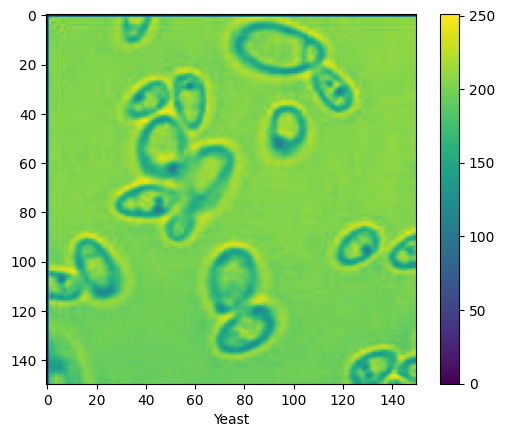

In [6]:
preview_train_data_index = 100

plt.figure()
plt.imshow(train_data[preview_train_data_index]['image'])
plt.colorbar()
plt.xlabel(train_data[preview_train_data_index]['classname'])
plt.grid(False)
plt.show()

## Show Preview of Test Data

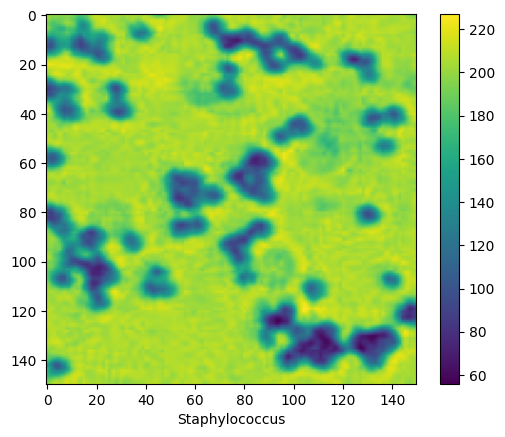

In [7]:
preview_test_data_index = 10

plt.figure()
plt.imshow(test_data[preview_test_data_index]['image'])
plt.colorbar()
plt.xlabel(test_data[preview_test_data_index]['classname'])
plt.grid(False)
plt.show()

# Hyperparameters


In [8]:
IMG_SHAPE = (150, 150)
INPUT_SHAPE = IMG_SHAPE + (1,)
KERNEL_SIZE = (3, 3)
conv_activation = 'relu'
activation = 'softmax'
MODEL_PARAMETERS = {
    'losses': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'optimizer': 'adam',
    'metrics': ['accuracy'],
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    ]
}


# Data processing


## Architecture


In [9]:
model = Sequential()

model.add(Conv2D(32, KERNEL_SIZE, activation=conv_activation, input_shape=INPUT_SHAPE))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, KERNEL_SIZE, activation=conv_activation))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, KERNEL_SIZE, activation=conv_activation))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, KERNEL_SIZE, activation=conv_activation))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation=conv_activation))
model.add(Dropout(0.5))

model.add(Dense(len(CLASS_NAMES), activation = activation))

## Summary


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

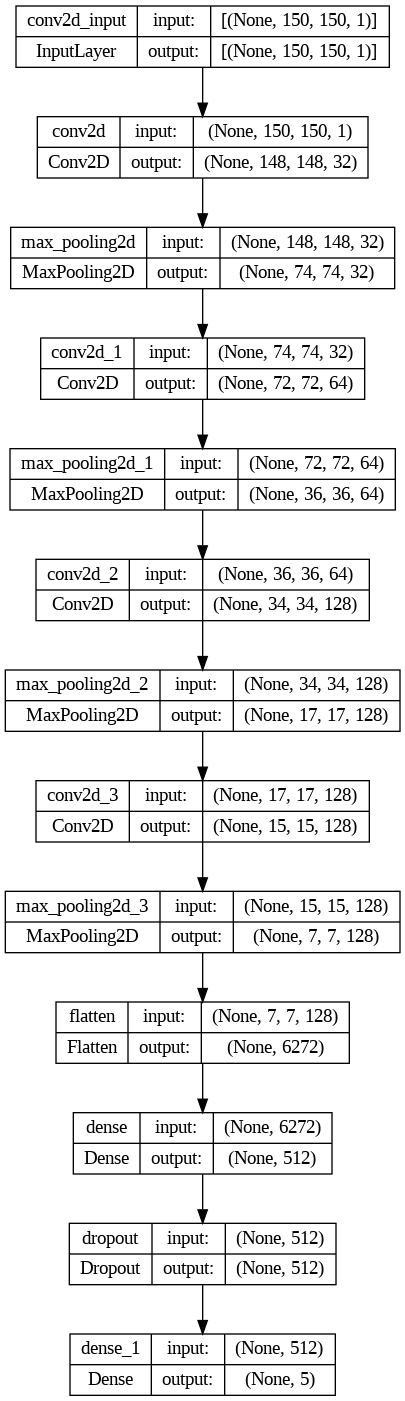

In [10]:
from tensorflow import keras

model.summary()
keras.utils.plot_model(model, 'model_arch.png', show_shapes=True)

# Compile and Train Model


In [11]:
model.compile(optimizer='adam',
              loss=MODEL_PARAMETERS['losses'],
              metrics=MODEL_PARAMETERS['metrics'],
              run_eagerly=True)

In [13]:
def resize_grayscale_image(image_array, target_size=(150, 150)):
    image_tensor = tf.expand_dims(tf.convert_to_tensor(image_array, dtype=tf.float32), axis=0)
    image_tensor = tf.expand_dims(image_tensor, axis=-1)

    resized_image = tf.image.resize(image_tensor, target_size)

    resized_image_array = tf.squeeze(resized_image).numpy()

    return resized_image_array

In [14]:
train_labels = [CLASS_NAMES.index(dc['classname']) for dc in train_data]
test_labels = [CLASS_NAMES.index(dc['classname']) for dc in test_data]

train_images = np.array([ resize_grayscale_image(dc['image']) for dc in train_data])
test_images = np.array([ resize_grayscale_image(dc['image']) for dc in test_data])

In [15]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [23]:
history = model.fit(
    train_images,
    train_labels,
    epochs=80,
    validation_data=(test_images, test_labels),
    batch_size=16,
    callbacks=MODEL_PARAMETERS['callbacks'])

Epoch 1/80
25/25 [==============================] - 6s 132ms/step - loss: 0.5383 - accuracy: 0.8359 - val_loss: 0.7950 - val_accuracy: 0.7308 - lr: 1.0000e-04
Epoch 2/80
25/25 [==============================] - 1s 39ms/step - loss: 0.5457 - accuracy: 0.8128 - val_loss: 0.8789 - val_accuracy: 0.6923 - lr: 1.0000e-04
Epoch 3/80
25/25 [==============================] - 1s 39ms/step - loss: 0.4929 - accuracy: 0.8231 - val_loss: 0.8304 - val_accuracy: 0.7308 - lr: 1.0000e-04
Epoch 4/80
25/25 [==============================] - 1s 39ms/step - loss: 0.5117 - accuracy: 0.8128 - val_loss: 0.8246 - val_accuracy: 0.6923 - lr: 1.0000e-04
Epoch 5/80
25/25 [==============================] - 1s 41ms/step - loss: 0.4766 - accuracy: 0.8385 - val_loss: 0.9510 - val_accuracy: 0.7308 - lr: 1.0000e-04
Epoch 6/80
25/25 [==============================] - 1s 46ms/step - loss: 0.4645 - accuracy: 0.8436 - val_loss: 0.8388 - val_accuracy: 0.6923 - lr: 1.0000e-04
Epoch 7/80
25/25 [==============================] -

In [24]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f'{test_acc*100}%')

1/1 - 0s - loss: 0.7950 - accuracy: 0.7308 - 38ms/epoch - 38ms/step
73.07692170143127%


# Performance

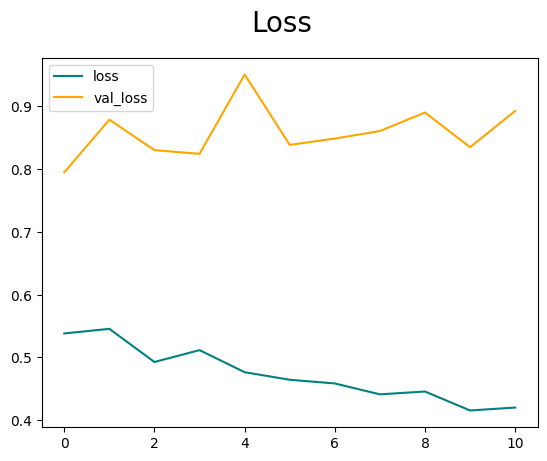

In [25]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

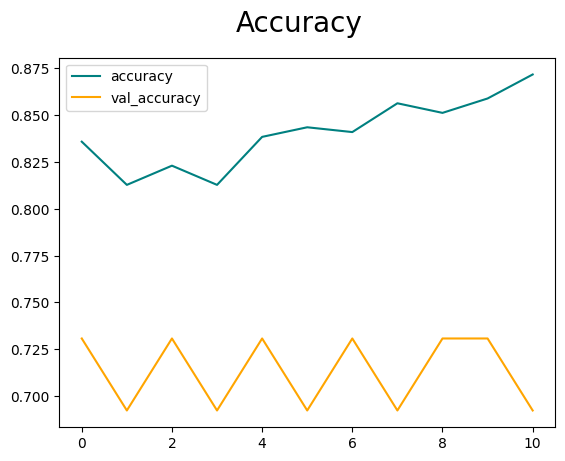

In [27]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Prediccion

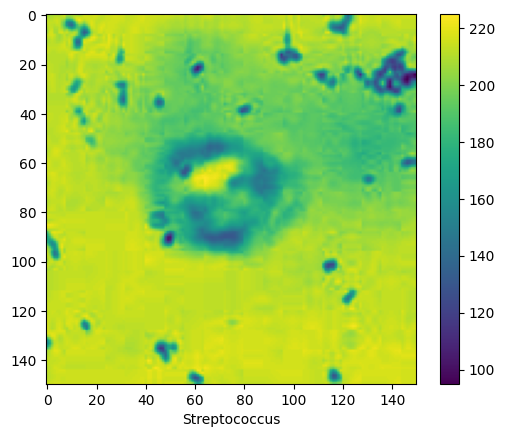

In [28]:
preview_valid_data_index = 10

plt.figure()
plt.imshow(valid_data[preview_valid_data_index]['image'])
plt.colorbar()
plt.xlabel(valid_data[preview_valid_data_index]['classname'])
plt.grid(False)
plt.show()

In [29]:
valid_images = np.array([ resize_grayscale_image(dc['image']) for dc in valid_data])

valid_image_test = valid_images[preview_valid_data_index]

In [30]:
valid_image_test.shape

(150, 150)

In [31]:
if valid_image_test.ndim == 2:  # Si la imagen tiene la forma (150, 150)
    valid_image_test = np.expand_dims(valid_image_test, axis=-1)  # Añadir la dimensión del canal

# Añadir la dimensión del batch (1, 150, 150, 1)
valid_image_test = np.expand_dims(valid_image_test, axis=0)

In [32]:
valid_image_test.shape

(1, 150, 150, 1)

In [33]:
# predict

predictions = model.predict(valid_image_test)

index_max = np.argmax(predictions[0])
index_min = np.argmin(predictions[0])

print(f"""
    The prediction is [MAX ARG]: {CLASS_NAMES[index_max]}
""")


1/1 [==============================] - 0s 282ms/step

    The prediction is [MAX ARG]: Streptococcus



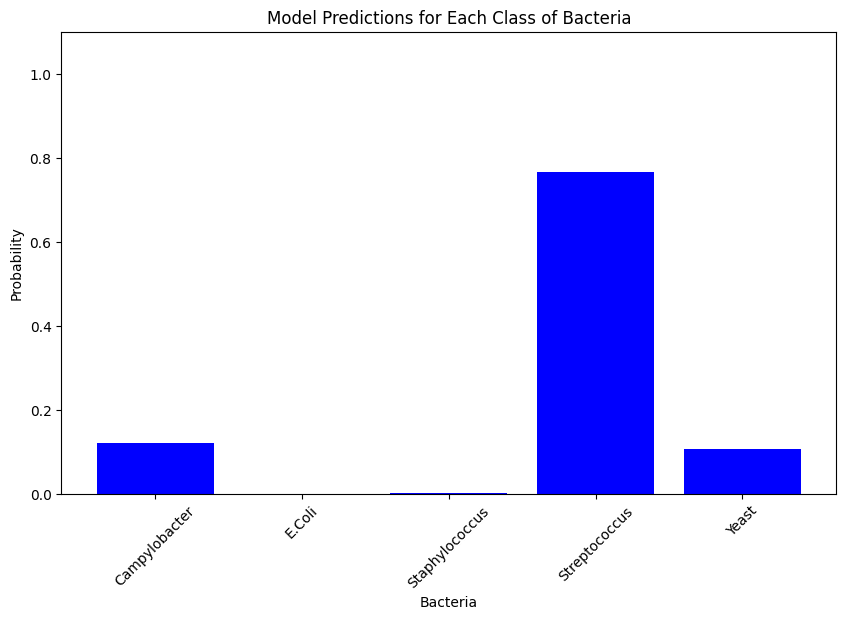

In [34]:

plt.figure(figsize=(10, 6))
plt.bar(CLASS_NAMES, predictions[0], color='blue')
plt.xlabel('Bacteria')
plt.ylabel('Probability')
plt.title('Model Predictions for Each Class of Bacteria')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)

plt.show()

In [35]:

MODELS_PATH = os.path.join(Path(os.getcwd()), 'models')

MODEL_EXTENSION = "h5"

MODEL_NAME = f"visualbacter_{INPUT_SHAPE}_{KERNEL_SIZE}"

MODEL_FULL_NAME = f"{MODEL_NAME}.{MODEL_EXTENSION}"


model.save(os.path.join(MODELS_PATH, MODEL_FULL_NAME))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# TF Lite

In [36]:
model_loaded =tf.keras.models.load_model(os.path.join(MODELS_PATH, MODEL_NAME + '.' + MODEL_EXTENSION))


converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)

tflite_model = converter.convert()


with open(f'{os.path.join(MODELS_PATH, MODEL_NAME)}.tflite', 'wb') as f:
    f.write(tflite_model)